In [37]:
import cv2
import torch
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'/opt/homebrew/bin/tesseract'
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from PIL import Image
from datetime import datetime
from albumentations.pytorch import ToTensorV2
from Training.configurations import MODEL_NAME
from Training.tablenet_model import TableNet
from Training.path_constants import PREDICTIONS, MODELS, TEST_IMAGES

In [38]:
TRANSFORM = A.Compose([
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
        max_pixel_value = 255,
    ),
    ToTensorV2()
])

In [39]:
def display_prediction(img, table = None, table_image = None, no_: bool = False):
  if no_:
    f1, ax  = plt.subplots(1, 1, figsize = (7, 5))
    ax.imshow(img)
    ax.set_title('Original Image')
    f1.suptitle('No Tables Detected')
  else:
    f2, ax  = plt.subplots(1, 3, figsize = (15, 8))
    ax[0].imshow(img)
    ax[0].set_title('Original Image')
    ax[1].imshow(table)
    ax[1].set_title('Image with Predicted Table')
    ax[2].imshow(table_image)
    ax[2].set_title('Predicted Table Example')
  plt.show()

In [40]:
model_path = f"{MODELS}/{MODEL_NAME}"
print(model_path)
model = TableNet(encoder = 'densenet', use_pretrained_model = True, basemodel_requires_grad = True)
model.eval()
# Load checkpoint
if torch.cuda.is_available():
    model.load_state_dict(torch.load(model_path)['state_dict'])
else:
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu'))['state_dict'])

./DummyDatabase/models/densenet_configuration_4_model_checkpoint.pth.tar


In [41]:
# Final prediction function, using the mask fixing method too
def predict(img_path):
    orig_image = Image.open(img_path).resize((1024, 1024))
    test_img = np.array(orig_image.convert('LA').convert("RGB"))
    now = datetime.now()
    image = TRANSFORM(image = test_img)["image"]
    with torch.no_grad():
        image = image.unsqueeze(0)
        table_out, _  = model(image)
        table_out = torch.sigmoid(table_out)
    # Remove gradients
    table_out = (table_out.detach().numpy().squeeze(0).transpose(1, 2, 0) > 0.5).astype(np.uint8)
    # Get contours of the mask to get number of tables
    contours, table_heirarchy = cv2.findContours(table_out, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    table_contours = []
    # Ref: https://www.pyimagesearch.com/2015/02/09/removing-contours-image-using-python-opencv/
    # Remove bad contours
    for c in contours:
        if cv2.contourArea(c) > 6000:
            table_contours.append(c)
    if len(table_contours) == 0:
        print("No Table detected")
    table_boundRect = [None] * len(table_contours)
    for i, c in enumerate(table_contours):
        polygon = cv2.approxPolyDP(c, 3, True)
        table_boundRect[i] = cv2.boundingRect(polygon)
    # Table bounding Box
    table_boundRect.sort()
    orig_image = np.array(orig_image)
    # Draw bounding boxes
    color = (0, 0, 255)
    thickness = 4
    for x,y,w,h in table_boundRect:
        cv2.rectangle(orig_image, (x , y), (x + w, y + h), color, thickness)
    # Show Original image with the table bordered extra
    plt.figure(figsize = (10, 5))
    plt.imshow(orig_image)
    end_time = datetime.now()
    difference = end_time - now
    time = "{}".format(difference)
    print(f"Time Taken on cpu: {time} secs")
    print("Predicted Tables")
    image = test_img[...,0].reshape(1024, 1024).astype(np.uint8)
    for i, (x, y, w, h) in enumerate(table_boundRect):
        image_crop = image[y : y + h, x : x + w]
        # Show only the table
        plt.figure(figsize = (7.5, 5))
        plt.imshow(image_crop)
        cv2.imwrite(f"/{PREDICTIONS}/image_crop.png", image_crop)
        data = pytesseract.image_to_string(image_crop)

In [42]:
from PIL import Image

def resize_content_with_background(image_path, scale_factor):
    # Open the image using Pillow
    img = Image.open(image_path)

    # Get the original image dimensions
    width, height = img.size

    # Calculate the new dimensions based on the scale factor
    new_width = int(width * scale_factor)
    new_height = int(height * scale_factor)

    # Resize the image while maintaining the aspect ratio
    resized_img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)

    # Create a new white background image with the original dimensions
    background = Image.new('RGB', (width, height), 'white')

    # Calculate the position to paste the resized image in the center
    x = int((width - new_width) / 2)
    y = int((height - new_height) / 2)

    # Paste the resized image onto the white background
    background.paste(resized_img, (x, y))

    # Save the modified image
    background.save(f'{TEST_IMAGES}/resized/resized_image.jpg')

# Usage example
_image_path = f'{TEST_IMAGES}/one.jpg'
resize_content_with_background(_image_path, 0.75)

./DummyDatabase/test_images/resized/resized_image.jpg
Time Taken on cpu: 0:00:00.888623 secs
Predicted Tables
None


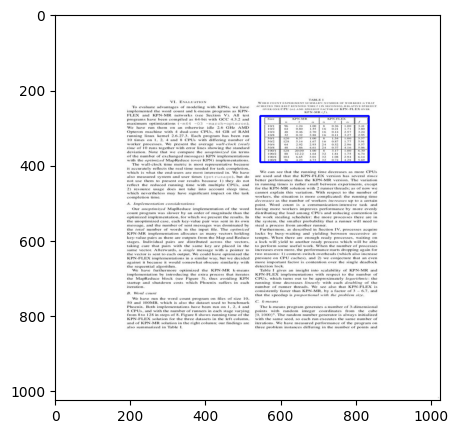

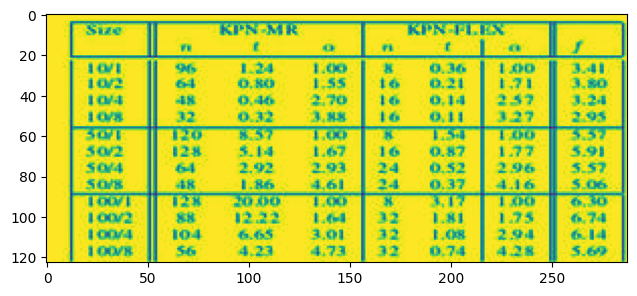

In [43]:
_image_path = f'{TEST_IMAGES}/resized/resized_image.jpg'
# _image_path = f'{TEST_IMAGES}/hand_drawn.jpg'
print(_image_path)
df = predict(img_path = _image_path)
print(df)